## 1. 이상치 개념 학습
## 2. 이상치 구하기
## 3. 이상치 시각화

In [79]:
#모듈 불러오기
import seaborn as sns
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
#데이터 불러오기
tt=sns.load_dataset('titanic')

In [81]:
tt

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## 1. 이상치 개념 학습
### (1) 정의
- 이상치 (Outlier): 어떤 특정 기준에 대하여 그 이상,이하인 값들
- 이상치는 도메인에 따른 정의가 중요함

### (2)이상치가 발생하는 이유
1. 데이터 입력 오류
2. 특정오류
3. 샘플링 오류
4. 자연 발생 이상치 
5. 데이터 처리 오류

### (3) 이상치 탐지
- 표준편차 (Z-Score)
- MAD (수정된 Z-Score)
- 사분위 수 (IQR)
- Isolation Forest
- DBSCAN(Density Based Spatial Clustering of Application with noise)
- LOF(Local Outlier Factor)


## 2. 이상치 구하기

### (1)Z-score

In [82]:
#넘파이와 stats을 가지고 z-score계산
z_score=np.abs(stats.zscore(tt['fare'].dropna())) #결측치 제거

In [83]:
stats.zscore(tt['fare'].dropna())

0     -0.502445
1      0.786845
2     -0.488854
3      0.420730
4     -0.486337
         ...   
886   -0.386671
887   -0.044381
888   -0.176263
889   -0.044381
890   -0.492378
Name: fare, Length: 891, dtype: float64

In [84]:
z_score#절대값

0      0.502445
1      0.786845
2      0.488854
3      0.420730
4      0.486337
         ...   
886    0.386671
887    0.044381
888    0.176263
889    0.044381
890    0.492378
Name: fare, Length: 891, dtype: float64

In [85]:
#임계값
threshold = 2.5
#임계값을 조절하면서 이상치가 얼마나 변하는지 확인
outliers_z=np.where(z_score>threshold)#이상치 인덱스 반환
outliers_z_vl=tt['fare'].dropna().iloc[outliers_z]
outliers_z_vl

27     263.0000
88     263.0000
118    247.5208
258    512.3292
299    247.5208
311    262.3750
318    164.8667
341    263.0000
377    211.5000
380    227.5250
438    263.0000
527    221.7792
557    227.5250
679    512.3292
689    211.3375
700    227.5250
716    227.5250
730    211.3375
737    512.3292
742    262.3750
779    211.3375
856    164.8667
Name: fare, dtype: float64

### (2)IQR

In [86]:
#quantile(): 분위수
Q1=tt['fare'].quantile(0.25)
Q3=tt['fare'].quantile(0.75)
IQR=Q3-Q1
Q1,Q3,IQR

(7.9104, 31.0, 23.0896)

In [87]:
#이상치의 기준을 정하자
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
lower_bound,upper_bound

(-26.724, 65.6344)

In [88]:
#이상치의 값들 추출
# lower bound보다 작고, upper bound보다 큰 값 -> 이상치
outlier_iqr=tt[(tt['fare']<lower_bound)|(tt['fare']>upper_bound)]['fare']
outlier_iqr

1       71.2833
27     263.0000
31     146.5208
34      82.1708
52      76.7292
         ...   
846     69.5500
849     89.1042
856    164.8667
863     69.5500
879     83.1583
Name: fare, Length: 116, dtype: float64

### (3)MAD

In [89]:
median_fare=tt['fare'].median()#중앙값구하기
mad=np.median(np.abs(tt['fare']-median_fare))
np.abs(tt['fare']-median_fare)

0       7.2042
1      56.8291
2       6.5292
3      38.6458
4       6.4042
        ...   
886     1.4542
887    15.5458
888     8.9958
889    15.5458
890     6.7042
Name: fare, Length: 891, dtype: float64

In [90]:
mad

6.9042

In [91]:
#임계값을 설정 
#통상적인 값: 3 , 3.5 
thershold_mad=3
# MAD Score 만들기:중앙값을 뺀 후 MAD로 나눔
mad_score=np.abs(tt['fare']-median_fare)/mad
mad_score

0      1.043452
1      8.231091
2      0.945685
3      5.597433
4      0.927580
         ...   
886    0.210625
887    2.251644
888    1.302946
889    2.251644
890    0.971032
Name: fare, Length: 891, dtype: float64

In [92]:
outliers_mad=tt[mad_score>thershold_mad]['fare']
outliers_mad

1       71.2833
3       53.1000
6       51.8625
23      35.5000
27     263.0000
         ...   
856    164.8667
863     69.5500
867     50.4958
871     52.5542
879     83.1583
Name: fare, Length: 198, dtype: float64

## 3. 이상치 시각화

In [93]:
# Z-Score 이상치
outliers_z_vl

27     263.0000
88     263.0000
118    247.5208
258    512.3292
299    247.5208
311    262.3750
318    164.8667
341    263.0000
377    211.5000
380    227.5250
438    263.0000
527    221.7792
557    227.5250
679    512.3292
689    211.3375
700    227.5250
716    227.5250
730    211.3375
737    512.3292
742    262.3750
779    211.3375
856    164.8667
Name: fare, dtype: float64

In [94]:
# IQR 이상치
outlier_iqr

1       71.2833
27     263.0000
31     146.5208
34      82.1708
52      76.7292
         ...   
846     69.5500
849     89.1042
856    164.8667
863     69.5500
879     83.1583
Name: fare, Length: 116, dtype: float64

In [95]:
# MAD 이상치
outliers_mad

1       71.2833
3       53.1000
6       51.8625
23      35.5000
27     263.0000
         ...   
856    164.8667
863     69.5500
867     50.4958
871     52.5542
879     83.1583
Name: fare, Length: 198, dtype: float64

In [96]:
# 이상치 데이터 프레임 만들기
# 보팅 방식으로 3개 모두 이상치 또는 2개이상 이상치라고 판정 시 이상치라고 정의할 수 있음 
# 이상치를 다양한 방법론으로 정의할 수 있음
outliers_df = pd.DataFrame({'Z-score': outliers_z_vl,
                           'IQR': outlier_iqr,
                           'MAD': outliers_mad})
outliers_df

,Z-score,IQR,MAD
1,NaN,71.2833,71.2833
3,NaN,NaN,53.1000
6,NaN,NaN,51.8625
23,NaN,NaN,35.5000
27,263.0000,263.0000,263.0000
...,...,...,...
856,164.8667,164.8667,164.8667
863,NaN,69.5500,69.5500
867,NaN,NaN,50.4958
871,NaN,NaN,52.5542


Text(0, 0.5, 'Fare')

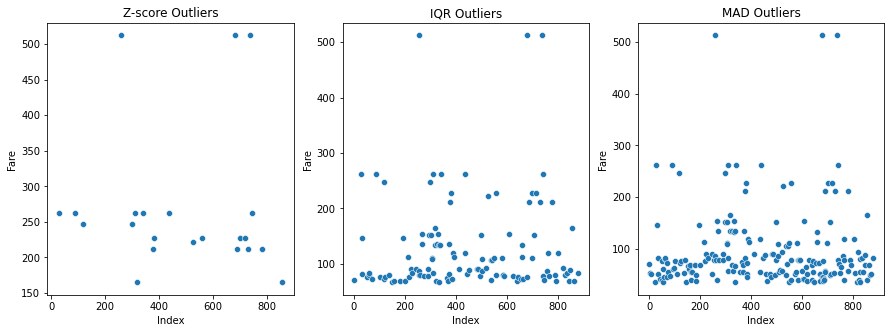

In [97]:
##이상치 시각화 비교 
plt.figure(figsize=(15,5))

# Z-score
plt.subplot(1,3,1)
sns.scatterplot(x=outliers_z_vl.index, y=outliers_z_vl)
plt.title('Z-score Outliers')
plt.xlabel('Index')
plt.ylabel('Fare')


# IQR
plt.subplot(1,3,2)
sns.scatterplot(x=outlier_iqr.index, y=outlier_iqr)
plt.title('IQR Outliers')
plt.xlabel('Index')
plt.ylabel('Fare')

# MAD
plt.subplot(1,3,3)
sns.scatterplot(x=outliers_mad.index, y=outliers_mad)
plt.title('MAD Outliers')
plt.xlabel('Index')
plt.ylabel('Fare')
# 이상치의 값이 다르게 나타나는 이유: 근본적인 이유는 다른 방법을 사용했기 때문(->이상치의 기준을 다르게 계산하였기 때문)
# 비즈니스 도메인에 따라 이상치, 임계값을 정의 내리는 일이 매우 중요함
# 데이터 분포,경향,치우침,왜도,첨도도 고려하여 분석해야 함

## 4. 데이터 분포
- 데이터의 분포, 경향, 치우침, 왜도, 첨도 등

### (1) 타이타닉 데이터

Text(0.5, 1.0, 'Q-Q plot of Fare')

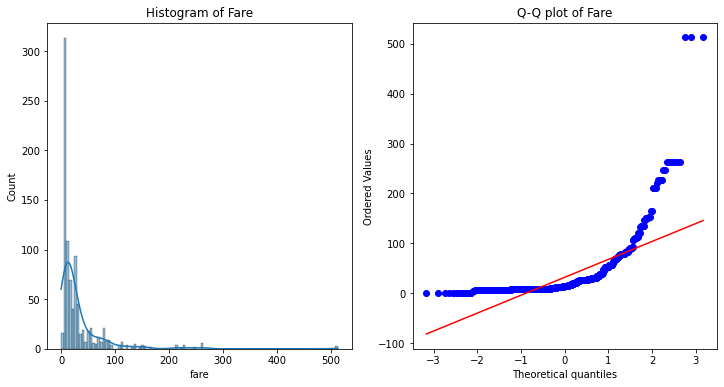

In [98]:
# 데이터의 분포 살펴보기
plt.figure(figsize=(12,6))

# 히스토그램
plt.subplot(1,2,1)
sns.histplot(tt['fare'].dropna(), kde=True)
plt.title('Histogram of Fare')

# Q-Q plot: 정규성
plt.subplot(1,2,2)
stats.probplot(tt['fare'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot of Fare')

In [99]:
tt['fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

### (2) 정규분포

In [100]:
# 정규분포 만들기
np.random.seed(42)

fare_normal = np.random.normal(loc=tt['fare'].mean(), scale = tt['fare'].std(), size=len(tt['fare']))
tt['fare_normal'] = fare_normal

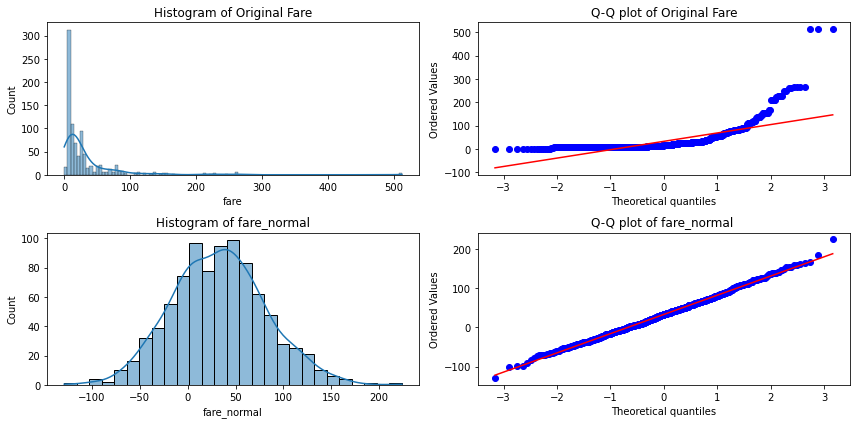

In [101]:
# 타이타닉 데이터 vs 정규분포 비교
plt.figure(figsize=(12,6))


# 타이타닉 데이터

# 히스토그램
plt.subplot(2,2,1)
sns.histplot(tt['fare'].dropna(), kde=True)
plt.title('Histogram of Original Fare')

# Q-Q Plot
plt.subplot(2,2,2)
stats.probplot(tt['fare'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot of Original Fare')


# 정규분포

# 히스토그램
plt.subplot(2,2,3)
sns.histplot(tt['fare_normal'].dropna(), kde=True)
plt.title('Histogram of fare_normal')

# Q-Q Plot
plt.subplot(2,2,4)
stats.probplot(tt['fare_normal'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot of fare_normal ')

plt.tight_layout()
plt.show()